In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lib import pseudo 
from scipy.optimize import minimize
import warnings
from warnings import warn
warnings.filterwarnings('error', category=UnicodeWarning)
import time 
import sys
import h5py
from itertools import combinations

%matplotlib inline

# Genetic algorithms

Genetic algorithms have 3 key features:
1. Heredity: Best solutions from previous generations must propagate to the next generation
2. Variation: Offspring from previous generations must mutate
3. Survival: Only a subset of the current generation must be picked for procreation

I have to express these 3 features mathematically. There are two others that go with it. 

Initial population. In the current case, this would be a set of zeros for the flat walled case

Fitness function. In this case, this is the above NSE. 

## Heredity
I should take two potential solutions from the previous generations and somehow merge them. I want to keep each Fourier mode intact, so I don't have to repeatedly look for divergence free basis. I can think of two rules. 

1. For each Fourier mode, pick coefficients from one of the parents randomly. 
2. Each offspring has exactly half of the Fourier modes from each parent.

How many such offsprings? That will be a hyperparameter.

In [3]:
def crossInd(nz, heredity='half'):
    """
    Returns an array of 0s and 1s of size nz, each referring to one parent.
    nz is the total number of Fourier modes.
    heredity='half' means that exactly half of the Fourier modes come from each parent.
    heredity='random' assigns parent randomly without worrying about number of modes from each."""
    assert nz%2 == 0
    M = nz//2
    np.random.seed()
    if heredity == 'half':
        indList = np.concatenate((np.zeros(M), np.ones(M)))
        np.random.shuffle(indList)
    if heredity == 'random':
        indList = np.random.randint(2, size=nz)
    
    return indList
        
def crossover_single(parent0, parent1, heredity='half'):
    """ Returns a single offspring"""
    assert parent0.shape == parent1.shape
    nz = parent0.shape[0]
    indList = crossInd(nz, heredity=heredity)
    offspring = np.copy(parent0)
    for lz in range(nz):
        if indList[lz] == 1:
            offspring[lz] = parent1[lz]
    
    # Impose real-valuedness
    for lz in range(1,nz//2):
        offspring[lz] = ( offspring[lz] + np.conj(offspring[-lz]) )/2.
        offspring[-lz] = np.conj(offspring[lz])
    offspring[nz//2] = np.real(offspring[nz//2]) 
    warn("Because I'm imposing real-valuedness, there's a bit of merging amongst modes")
    
    return offspring

def crossover_multiple(parent0, parent1, heredity='half', num_off=4):
    offspringList = []
    for num in range(num_off):
        offspringList.append(crossover_single(parent0, parent1, heredity=heredity))
    
    return offspringList

def propagate(parentList,heredity='half', num_off=4):
    indList = np.arange(len(parentList))
    offspringList = []
    # Use itertools.combinations to create combinations of pairs from parentList
    for indPair in combinations(indList, 2):
        parent0 = parentList[indPair[0]]
        parent1 = parentList[indPair[1]]
        offspringList.extend(crossover_multiple(parent0,parent1, 
                            heredity=heredity, num_off=num_off))
    return offspringList

In [4]:
parent0 = np.array([0,0,0,2,0,0]).reshape((6,1)).astype(np.float)
parent1 = np.array([4,6,4,6,4,6]).reshape((6,1)).astype(np.float)
parent2 = np.array([14,16,14,16,14,16]).reshape((6,1)).astype(np.float)
parent3 = np.array([24,26,24,26,24,26]).reshape((6,1)).astype(np.float)



print(crossover_single(parent0, parent1,heredity='random').flatten())
print(crossover_single(parent0, parent1,heredity='random').flatten())
print(crossover_single(parent0, parent1,heredity='random').flatten())
print(crossover_single(parent0, parent1,heredity='random').flatten())
print(crossover_single(parent0, parent1,heredity='random').flatten())
print(crossover_single(parent0, parent1,heredity='random').flatten())
print(crossover_single(parent0, parent1,heredity='random').flatten())
print(crossover_single(parent0, parent1,heredity='random').flatten())

print(); print()
offList = propagate([parent0,parent1,parent2,parent3], num_off=1)
for offspring in offList:
    print(offspring.flatten())

[0. 6. 0. 6. 0. 6.]
[4. 3. 2. 2. 2. 3.]
[0. 6. 0. 2. 0. 6.]
[0. 3. 4. 2. 4. 3.]
[4. 3. 2. 2. 2. 3.]
[4. 6. 4. 6. 4. 6.]
[4. 3. 2. 2. 2. 3.]
[4. 6. 2. 2. 2. 6.]


[0. 3. 2. 6. 2. 3.]
[ 0.  8. 14.  2. 14.  8.]
[ 0. 26. 12.  2. 12. 26.]
[14. 11.  9.  6.  9. 11.]
[ 4. 26. 14.  6. 14. 26.]
[14. 21. 19. 26. 19. 21.]


C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Because I'm imposing real-valuedness, there's a bit of merging amongst modes


## Variation
This bit is going to be challenging. Coming up with random mutations isn't a problem. The problem is finding the right magnitude for these mutations. I'll use line search combined with a binary search. Set initial magnitude of mutations to the magnitude of the energy of the Fourier mode. Then, do binary search between, say, -5 and +10 times this magnitude for 10 steps. 

The number of variations per offspring with the same heredity will be a hyperparameter. 

In [44]:
norm = np.linalg.norm

# Keep mutations on the same scale as the norm of each Fourier mode (times relaxation factor 'relax')
def mutate_single(oldOffspring, relax=1.):
    offspring = np.copy(oldOffspring)
    np.random.seed()
    nz,N = offspring.shape
    for lz in range(nz//2+1):
        offspring[lz] += (np.random.randn(N) )*(1.e-9 + norm(offspring[lz])) * relax
        # Adding -0.5 keeps random in [-0.5, 0.5]
        # Multiplying with norm scales to original
        offspring[-lz] = np.conj(offspring[lz])
    
    offspring[nz//2] = np.real(offspring[nz//2])
    return offspring

def mutate_multiple(offspring, num_mut=4,relax=1.):
    offspringList = []
    for num in range(num_mut):
        offspringList.append(mutate_single(offspring, relax=relax))
    
    return offspringList

def mutate(offspringList, num_mut=1,relax=1.):
    nextgenList = []
    for offspring in offspringList:
        nextgenList.extend(mutate_multiple(offspring, num_mut=num_mut, relax=relax))
    return nextgenList

In [45]:
parent0 = np.array([0,0,0,2,0,0]).reshape((6,1)).astype(np.float)
parent1 = np.array([4,6,4,6,4,6]).reshape((6,1)).astype(np.float)
offspring01 = crossover_single(parent0, parent1,heredity='random')
print(offspring01.flatten())

print(mutate_single(offspring01,relax=2.).flatten())
print(mutate_single(offspring01,relax=2.).flatten())
print(mutate_single(offspring01,relax=1.).flatten())
print(mutate_single(offspring01,relax=0.5).flatten())
print(mutate_single(offspring01,relax=0.1).flatten())

[4. 3. 2. 2. 2. 3.]
[9.206 6.278 1.588 3.938 1.588 6.278]
[ 8.682 -4.702  6.935  0.745  6.935 -4.702]
[ 4.138 10.383  3.092  1.771  3.092 10.383]
[2.638 5.365 2.414 0.473 2.414 5.365]
[3.96  3.107 1.795 2.273 1.795 3.107]


C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Because I'm imposing real-valuedness, there's a bit of merging amongst modes


## Selection
This bit is easy. Just pick the 'n' best performers. 'n' is a hyperparameter. 

In [46]:
def select(offspringList, selFun, num_next=4):
    if num_next >= len(offspringList):
        num_next = len(offspringList)//2
    
    residualList = []
    for offspring in offspringList:
        residualList.append(selFun(offspring))
    
    indList = np.argsort(residualList)
    surviveList = []
    for ind in indList[:num_next]:
        surviveList.append(offspringList[ind])
    
    return surviveList

In [47]:
soln = np.linspace(0., 1., 8).reshape((4,2))
selFun = lambda candidate: norm(candidate-soln)

parent0 = np.zeros(soln.shape)
parent1 = np.ones(soln.shape)
parent2 = soln + 0.01*np.ones(soln.shape)

print(parent0.flatten(), selFun(parent0))
print(parent1.flatten(), selFun(parent1))
print(parent2.flatten(), selFun(parent2))

[0. 0. 0. 0. 0. 0. 0. 0.] 1.6903085094570331
[1. 1. 1. 1. 1. 1. 1. 1.] 1.6903085094570331
[0.01  0.153 0.296 0.439 0.581 0.724 0.867 1.01 ] 0.028284271247461922


In [48]:
def repeatIndices(costArr, genx2):
    # Find repeating members
    index_sets = [np.argwhere(i==costArr) for i in np.unique(costArr)] 
    # List of arrays; each array is an index for members with same cost
    new_index_sets = [np.argwhere(i[0]== costArr) for i in np.array(np.unique(costArr, return_counts=True)).T if i[1]>=2] 
    # Same as above, but arrays with single index dropped
    
    dropList = []
    for indArr in new_index_sets:
        #indArr contains 2 or more indices that could be due to the same member
        ind0 = indArr[0]
        for ind1 in indArr[1:]:
            if np.allclose(genx2[ind0[0]], genx2[ind1[0]]):
                dropList.append(ind1[0])
    dropList = np.sort(np.array(dropList))[::-1] 
    #sort in descending order so deleting later elements doesn't mess with previous ones
    return dropList


In [49]:
soln = np.linspace(0., 1., 8).reshape((4,2))
num_off = 10  # Number of pre-mutation offspring
num_mut = 2   # Branch into so many offspring from the pre-mutation number
num_next = 10 # Keep at most so many members for next generation
newMems = 5   # Introduce so many new members with random genetics
newTime = 20  # Introduce new members in this interval
heredity='half'
selFun = lambda candidate: norm(candidate-soln)

parentList = []
for pnum in range(100):
    parentList.append(np.random.rand(4,2))
#parentList = [parent0,parent1]

gen1 = parentList
genx2 = gen1
oldMems = genx2

np.set_printoptions(precision=3) 
print(soln.flatten())
costArr = np.array([selFun(mem) for mem in genx2])

for genNum in range(1000):
    if genNum%newTime == 0 :
        # Introduce new members every 5 generations
        for ind in range(newMems):
            genx2.append(np.random.rand(4,2))
    
    if len(genx2) < num_next:
        tmp = len(genx2)
        for ind in range(num_next-tmp):
            genx2.append(np.random.rand(4,2))
        
    genx0 = propagate(genx2,num_off=num_off,heredity=heredity)
    genx1 = mutate(genx0, num_mut=num_mut, relax=0.5*np.average(costArr)**0.7)
    
    #genx1.extend(genx0)  # Include non-mutated offspring
    genx1.extend(genx2)  # Include parents
    
        
    genx2 = select(genx1, selFun, num_next=num_next)
    costArr = np.array([selFun(mem) for mem in genx2])
    
    # Delete repeating members
    ind = 0
    while ind < len(genx2):
        if ind >= len(genx2)-1: break
        mem0 = genx2[ind]
        for ind1 in np.arange(ind+1, len(genx2))[::-1]:
            mem1 = genx2[ind1]
            if np.allclose(mem0.flatten(),mem1.flatten()): 
                del genx2[ind1]
        ind += 1    
    
    # If members live for more than 10 gens, kill them
    if genNum > 1 and (genNum%5 == 0):
        for ind in np.arange(len(genx2))[::-1]:
            mem0 = genx2[ind]
            for mem1 in oldMems:
                if np.allclose(mem0.flatten(), mem1.flatten()):
                    del genx2[ind]
                    break
    oldMems = np.copy(genx2)
    
    if (genNum % 100 == 0) and (genNum>0):
        print()
        print(genNum+1, costArr)
        for mem in genx2:
            print(mem.flatten())

print();print("End of iterations:")            
print(genNum+1, costArr)
for mem in genx2:
    print(mem.flatten())            



[0.    0.143 0.286 0.429 0.571 0.714 0.857 1.   ]


C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Because I'm imposing real-valuedness, there's a bit of merging amongst modes



101 [0.583 0.583 0.584 0.584 0.588 0.593 0.599 0.601 0.601 0.601]
[-0.009  0.118  0.549  0.764  0.511  0.665  0.549  0.764]
[-0.04   0.182  0.528  0.74   0.634  0.69   0.528  0.74 ]
[0.025 0.181 0.633 0.693 0.565 0.775 0.633 0.693]
[0.068 0.112 0.507 0.678 0.547 0.759 0.507 0.678]
[0.098 0.216 0.499 0.67  0.591 0.669 0.499 0.67 ]
[0.051 0.187 0.526 0.647 0.45  0.672 0.526 0.647]
[-0.008  0.061  0.458  0.686  0.581  0.733  0.458  0.686]

201 [0.574 0.581 0.581 0.587 0.59  0.591 0.592 0.593 0.596 0.596]
[-0.034  0.13   0.56   0.723  0.556  0.692  0.56   0.723]
[-0.01   0.195  0.565  0.704  0.631  0.645  0.565  0.704]
[-0.038  0.151  0.642  0.729  0.471  0.733  0.642  0.729]
[-0.02   0.096  0.646  0.682  0.556  0.625  0.646  0.682]
[-0.048  0.102  0.541  0.794  0.472  0.72   0.541  0.794]
[-0.018  0.147  0.623  0.789  0.571  0.825  0.623  0.789]

301 [0.586 0.591 0.591 0.592 0.593 0.593 0.594 0.596 0.598 0.6  ]
[0.062 0.019 0.579 0.73  0.621 0.704 0.579 0.73 ]
[0.012 0.253 0.566 0.634 0.

# An exceptionally simple evolutionaty algorithm

In [57]:
parent = np.random.rand(4,2)
alpha = 2**(1./8.)
iterMax = 1000
iterPrint = 50
std = 0.5

for iternum in range(iterMax):
    offspring = parent + np.random.normal(0., std, parent.shape)
    costOff = selFun(offspring)
    costPar = selFun(parent)
    
    if costOff <= costPar:
        parent = offspring
        std = std*alpha
    else :
        parent = parent
        std = std* alpha**(-1./4.)
    
    if iternum%iterPrint == 0:
        print(iternum, costOff, offspring.flatten())
    
    if min(costOff,costPar) < 1.e-3:
        print(); print("Exiting...")
        print(iternum, min(costOff,costPar))
        print(parent.flatten())
        print(soln.flatten())
        break

0 1.7311711615731873 [0.641 0.039 0.365 0.349 1.288 1.547 0.173 0.058]
50 1.1320446023351267 [-0.421 -0.266 -0.248  0.604  0.434  0.268  0.567  1.565]
100 0.41720050739400694 [0.054 0.27  0.259 0.655 0.729 0.59  0.674 1.171]
150 0.18405896817538178 [-0.072  0.123  0.311  0.414  0.519  0.804  0.799  0.884]
200 0.1477518915648664 [-0.081  0.082  0.322  0.377  0.597  0.724  0.868  0.919]
250 0.12243598572431677 [0.09  0.154 0.339 0.482 0.563 0.682 0.849 0.998]
300 0.05002482976776628 [0.027 0.129 0.315 0.453 0.574 0.711 0.861 0.991]
350 0.031116354908113358 [-0.007  0.128  0.306  0.425  0.577  0.714  0.86   0.984]
400 0.020176271174065414 [-0.004  0.139  0.292  0.432  0.563  0.716  0.866  0.987]
450 0.006960904551888521 [-0.002  0.142  0.289  0.427  0.574  0.712  0.853  0.998]
500 0.005718009904293208 [0.001 0.142 0.282 0.431 0.572 0.714 0.859 1.001]
550 0.002994543085636116 [-1.999e-04  1.439e-01  2.863e-01  4.268e-01  5.706e-01  7.134e-01
  8.561e-01  9.987e-01]

Exiting...
572 0.000947

# Longitudinal grooves, laminar

The NSE reduce to 
$$ \Delta u = 0 $$
which can be written for each (spanwise) Fourier mode as
$$ -\epsilon^2 \beta^2 u_{k-2}''  + (2k-1)\epsilon \beta^2 u_{k-1}'
-k^2 \beta^2 + (1+2\epsilon^2 \beta^2) u_k'' 
+ (-2k-1)\epsilon \beta^2 u_{k+1}'-\epsilon^2 \beta^2 u_{k+2}'' = 0 $$

I need to solve this equation for a bunch of $k$. 

In [184]:
from lib.pseudo import chebnorm
from lib.pseudo import chebdif

N = 15
M = 5
norm = lambda arr: chebnorm(arr,N)
y,DM = pseudo.chebdif(N,2)
D1 = DM[:,:,0]
D2 = DM[:,:,1]

def residFun(state, eps, beta):
    # State is ordered as (-M,-M+1,..,0,..,M)
    g = eps*beta
    assert state.size == (2*M+1)*N
    state = state.reshape((-1,N))
    assert norm(state - np.conj(state[::-1])) <= 1.e-9
    statePad = np.zeros((2*M+5, N),dtype=np.complex)
    statePad[2:-2] = state
    cost = -2.
    for kind in range(2, 2*M+3):
        k = -M + kind - 2
        cost += norm(
            -g**2 * (D2@ (statePad[kind-2] + statePad[kind+2])  ) 
            +(2.*k-1)*eps*beta**2 * D1@statePad[kind-1] + (-2.*k-1.)*eps*beta**2 * D1@statePad[kind+1] 
            -k**2*beta**2 * statePad[kind] + (1. + 2.*g**2)* D2@statePad[kind]   )
    return abs(cost)


In [185]:
eps = 0.025; beta = 1.; 
state = np.zeros((2*M+1,N),dtype=np.complex)
state[M] = 1.-y**2
residFun(state,eps,beta)

0.062735026918963

## Scale mutations by Fourier mode
It doesn't make sense to have similar distributions for mutations in different Fourier modes. We want the 0th and 1st modes to have a fair bit of energy, while later modes don't have as much. I'll model this using an array of scaling factors that is supplied to the problem, and made use of in the following function.

In [186]:
def getMutation(stdArr, M, y,m=None):
    mutation = np.zeros((2*M+1, y.size), dtype=np.complex)
    if m is None:
        for lz in range(M,2*M+1):
            mutation[lz] = (1.-y**2)*( 
                np.random.normal(0., stdArr[lz], (1,y.size) ) + 
                1.j* np.random.normal(0., stdArr[lz], (1,y.size) )    )
    else :
        mutation[M+abs(m)] = (1.-y**2)*( 
                np.random.normal(0., stdArr[M+abs(m)], (1,y.size) ) + 
                1.j* np.random.normal(0., stdArr[M+abs(m)], (1,y.size) )    )
    
    mutation[M-1::-1] = np.conj(mutation[M+1:])
    mutation[M] = np.real(mutation[M])
    
    return mutation

In [237]:
eps = 0.1; beta = 0.01; 
g = eps*beta
#parent = np.zeros((2*M+1, N), dtype=np.complex)
#parent[M] = 1.-y**2
    
#alpha = 2**(1./parent.size/2.)
alpha = 1.05
print("alpha:",alpha)
iterMax = 10000
iterPrint = 10
tol = 1.e-14

# Define initial standard deviation using g=eps*beta as a proxy
if True:
    stdArr = 5.e-5 * np.ones(2*M+1)

np.set_printoptions(precision=4)
for iternum in range(iterMax):
    if (iternum<50) or (iternum%20):
        for m in range(M+1):
            offspring = parent + getMutation(stdArr, M, y,m=m)
            costOff = residFun(offspring,eps,beta)
            costPar = residFun(parent,eps,beta)

            if costOff <= costPar:
                parent = np.copy(offspring)
                stdArr[M+m] = stdArr[M+m]*alpha
            else :
                parent = parent
                stdArr[M+m] = stdArr[M+m] * alpha**(-1./4.)
    else :
        offspring = parent + getMutation(stdArr, M, y)
        costOff = residFun(offspring,eps,beta)
        costPar = residFun(parent,eps,beta)

        if costOff <= costPar:
            parent = np.copy(offspring)
            stdArr = stdArr*alpha
        else :
            parent = parent
            stdArr = stdArr * alpha**(-1./4.)
        
    if min(costOff,costPar) < tol:
        print(); print("Exiting...")
        print(iternum, min(costOff,costPar))
        break

    if iternum <= 10:
        print(iternum, min(costOff, costPar), stdArr[0],stdArr[M])
    
    if (10 < iternum <= 100):
        if iternum%10 == 0:
            print(iternum, min(costOff, costPar),stdArr[0],stdArr[M])
    
    if (100 < iternum <= 1000):
        if iternum%100 == 0:
            print(iternum, min(costOff, costPar),stdArr[0],stdArr[M])
    
    if (1000 < iternum <= 10000):
        if iternum%500 == 0:
            print(iternum, min(costOff, costPar),stdArr[0],stdArr[M])
    
    

alpha: 1.05
0 0.0012865729142105486 5e-05 5.25e-05
1 0.0012865729142105486 5e-05 5.186351873971139e-05
2 0.0011925525403711237 5e-05 5.123475382979799e-05
3 0.0011537689040443748 5e-05 5.3796491521287895e-05
4 0.0010996718227991044 5e-05 5.6486316097352294e-05
5 0.0010029077688005759 5e-05 5.5801506922900795e-05
6 0.0009621312098404119 5e-05 5.5125000000000005e-05
7 0.0009621312098404119 5e-05 5.4456694676696966e-05
8 0.0009573031859442715 5e-05 5.7179529410531814e-05
9 0.0009379291825378688 5e-05 6.003850588105841e-05
10 0.0009379291825378688 5e-05 5.931063190221991e-05
20 2.7724596058098923e-06 5e-05 5.93106319022199e-05
30 2.7724596058098923e-06 5e-05 5.249999999999998e-05
40 2.7724596058098923e-06 5e-05 4.647143204516821e-05
50 2.7724596058098923e-06 5e-05 4.1135123739594056e-05
60 2.7724596058098923e-06 4.9393827371153705e-05 3.641158300065011e-05
70 1.4380396091023026e-07 4.9393827371153705e-05 3.4257284667515174e-05
80 1.4380396091023026e-07 4.8795003647426656e-05 3.032352526625

In [238]:
soln0 = (1.-2.*(eps*beta)**2 )*(1.-y**2)
soln1 = (eps*beta**2)/3. * (y**3 - y )
np.real(parent[M+1]-soln1), np.real(soln1)

(array([ 0.    , -0.0041, -0.0149, -0.0267, -0.033 , -0.0297, -0.0171,
         0.0003,  0.0176,  0.0295,  0.0329,  0.0266,  0.0148,  0.0041,
         0.    ]),
 array([ 0.0000e+00, -1.6091e-07, -5.6537e-07, -1.0131e-06, -1.2704e-06,
        -1.1740e-06, -7.0501e-07,  0.0000e+00,  7.0501e-07,  1.1740e-06,
         1.2704e-06,  1.0131e-06,  5.6537e-07,  1.6091e-07,  0.0000e+00]))

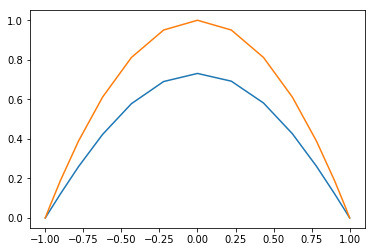

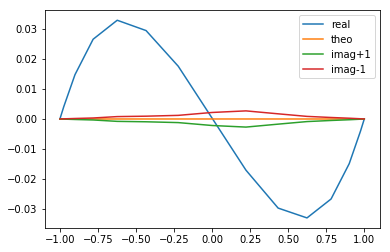

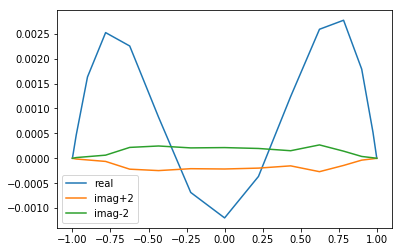

In [239]:
plt.plot(y, np.real(parent[M])) 
plt.plot(y, soln0)
plt.show()

plt.plot(y, np.real(parent[M+1]),label='real')
plt.plot(y, soln1, label='theo')
plt.plot(y, np.imag(parent[M+1]),label='imag+1')
plt.plot(y, np.imag(parent[M-1]),label='imag-1')
plt.legend()
plt.show()

plt.plot(y, np.real(parent[M+2]),label='real')
plt.plot(y, np.imag(parent[M+2]),label='imag+2')
plt.plot(y, np.imag(parent[M-2]),label='imag-2')
plt.legend()
plt.show()



In [233]:
residFun(parent, eps, beta)

1.725453547402056e-15